Submission for https://www.kaggle.com/c/dog-breed-identification

Some sections of code taken from - https://www.kaggle.com/kaggleslayer/simple-convolutional-n-network-with-tensorflow

Transfer learning from - https://github.com/jiexunsee/New-Simple-Inception-Transfer-Learning

# Reading Data files

In [2]:
#We upload all the packages we need
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation.
import PIL.Image
from IPython.display import display
#from resizeimage import resizeimage

#Panda
import pandas as pd

#Open a Zip File
from zipfile import ZipFile
from io import BytesIO

#check tensorflow version
tf.__version__

'1.0.0'

In [6]:
# This function help to create  a pickle file gathering all the image from a zip folder
###############
def DataBase_creator(directory, nwigth, nheight, save_name):
    #We choose the archive (zip file) + the new wigth and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    files = os.listdir(directory)
    s = (len(files), nwigth, nheight,3) #nwigth x nheight = number of features because images are nwigth x nheight pixels
    allImage = np.zeros(s)
    
    for i in range(1,len(files)):
        filename = os.path.join(directory,files[i])
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwigth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
    
    #we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [7]:
image_resize = 60
DataBase_creator(directory = "train", nwigth = image_resize, nheight = image_resize , save_name = "train")
DataBase_creator(directory = "test", nwigth = image_resize, nheight = image_resize , save_name = "test")

Time usage: 0:04:40
Time usage: 0:05:06


In [8]:
#load TRAIN
train = pickle.load( open( "train.p", "rb" ) )
train.shape
#load TEST
test = pickle.load( open( "test.p", "rb" ) )
test.shape

(10357, 60, 60, 3)

In [9]:
df_train= pd.read_csv('labels.csv')
df_train.sample(5)

,id,breed
6071,9967da09835c2259a11196be6783c2f3,cocker_spaniel
7738,c1ca7ec9bb04a6b33e8780cf944d3184,miniature_pinscher
8884,dec0bb81afcfc4c35c7c6790975e5633,pomeranian
9649,f2d5c11258efb9e8de45a81a6982f8f2,irish_terrier
5897,94c4d59a7e93326c11db4bb1d0ca8a23,papillon


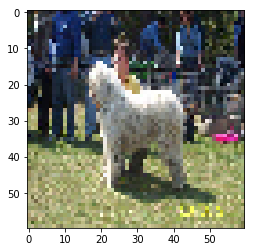

In [10]:
#let's check one image from the train data base
lum_img = train[100,:,:,:]
plt.imshow(lum_img)
plt.show()

In [27]:
Nber_of_breeds = 10

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(df_train["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = df_train["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = df_train, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = df_train.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

TypeError: unhashable type: 'numpy.ndarray'

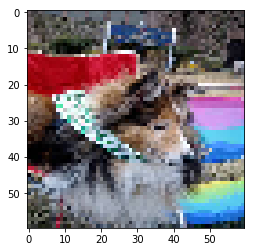

In [16]:
#print(labels_filtered[90])
lum_img = train_filtered[1,:,:,:]
plt.imshow(lum_img)
plt.show()

In [17]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(1141, 1)

In [18]:
#Function to breate one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [19]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 10
Shape : (1141, 10)


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [20]:
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))

Breed 0 : afghan_hound
Breed 1 : basenji
Breed 2 : bernese_mountain_dog
Breed 3 : entlebucher
Breed 4 : great_pyrenees
Breed 5 : maltese_dog
Breed 6 : pomeranian
Breed 7 : samoyed
Breed 8 : scottish_deerhound
Breed 9 : shih-tzu


In [21]:
labels[0:9]

array([['basenji'],
       ['scottish_deerhound'],
       ['maltese_dog'],
       ['shih-tzu'],
       ['samoyed'],
       ['scottish_deerhound'],
       ['entlebucher'],
       ['entlebucher'],
       ['maltese_dog']], dtype=object)

In [22]:
#You can proceed backward with np.argmax to find the breed of an image
labels_cls = np.argmax(labels_bin, axis=1)
labels_name[labels_cls[2]]

'maltese_dog'

shih-tzu


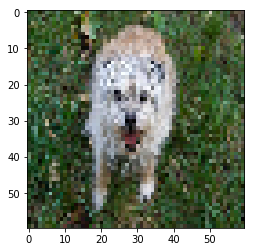

In [23]:
i=11
print(labels_name[labels_cls[i]])
lum_img = train_filtered[i,:,:,:]
plt.imshow(lum_img)
plt.show()

In [24]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)
X_train.shape

(798, 60, 60, 3)

In [26]:
#from the one-hot database we can find the breed.
df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([6, 4, 7, 2, 6, 9, 1, 1, 8], dtype=int64)

samoyed
7


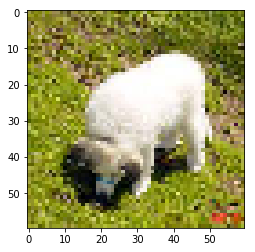

In [27]:
i=2
print(labels_name[df_validation_toPred_cls[i]])
print(df_validation_toPred_cls[i])
lum_img = X_validation[i,:,:,:]
plt.imshow(lum_img)
plt.show()

# Coming to Transfer Learning, Producing bottlenecks from Inception V3 architecture

In [1]:
#dependent modules
import argparse
from datetime import datetime
import hashlib
import os.path
import random
import re
import struct
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import tensor_shape
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

In [2]:
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
BOTTLENECK_TENSOR_SIZE = 2048
MODEL_INPUT_WIDTH = 60
MODEL_INPUT_HEIGHT = 60
MODEL_INPUT_DEPTH = 3
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'
RESIZED_INPUT_TENSOR_NAME = 'ResizeBilinear:0'
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M

In [3]:
model_dir = 'inception'
image_dir = 'test'
bottleneck_dir = 'bottlenecks'


In [4]:
def create_bottleneck_file(sess, jpeg_data_tensor, bottleneck_tensor):

	file_list = []
	file_glob = os.path.join(image_dir, '*.jpg')
	file_list.extend(gfile.Glob(file_glob))

	for image in file_list:
		# getting the name of the training image
		image_name = str(image).split('/')[-1]
		path = bottleneck_dir+'/'+image_name+'.txt'
		print('Creating bottleneck at ' + path)

		image_data = gfile.FastGFile(image, 'rb').read()
		bottleneck_values = run_bottleneck_on_image(sess, image_data, jpeg_data_tensor, bottleneck_tensor)
		bottleneck_string = ','.join(str(x) for x in bottleneck_values)
		with open(path, 'w') as bottleneck_file:
			bottleneck_file.write(bottleneck_string)

In [5]:
def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            bottleneck_tensor):
	bottleneck_values = sess.run(bottleneck_tensor, {image_data_tensor: image_data})
	bottleneck_values = np.squeeze(bottleneck_values)
	return bottleneck_values

In [6]:
def maybe_download_and_extract():
	dest_directory = model_dir
	if not os.path.exists(dest_directory):
		os.makedirs(dest_directory)
	filename = DATA_URL.split('/')[-1]
	filepath = os.path.join(dest_directory, filename)
	if not os.path.exists(filepath):

		def _progress(count, block_size, total_size):
			sys.stdout.write('\r>> Downloading %s %.1f%%' %(filename, float(count * block_size) / float(total_size) * 100.0))
			sys.stdout.flush()

		filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
		print()
		statinfo = os.stat(filepath)
		print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
	tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [7]:
def create_inception_graph():
	with tf.Session() as sess:
		model_filename = os.path.join(model_dir, 'classify_image_graph_def.pb')
		with gfile.FastGFile(model_filename, 'rb') as f:
			graph_def = tf.GraphDef()
			graph_def.ParseFromString(f.read())
			bottleneck_tensor, jpeg_data_tensor, resized_input_tensor = (tf.import_graph_def(graph_def, name='', return_elements=[BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME, RESIZED_INPUT_TENSOR_NAME]))
	return sess.graph, bottleneck_tensor, jpeg_data_tensor, resized_input_tensor

# Create Pickle from Bottleneck files

In [34]:
import csv

# This function help to create  a pickle file gathering all the image from a zip folder
###############
def BottleNeck_DataBase_creator(directory, save_name):
    #We choose the archive (zip file) and create a pickle from this
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    files = os.listdir(directory)
    BottleNeck = dict()
    #s = (len(files), 2048) #nwigth x nheight = number of features because images are nwigth x nheight pixels
    #BottleNeck = np.zeros(s)
    
    for i in range(0,len(files)):
        filename = os.path.join(directory,files[i])
        filename_index, file_extension = os.path.splitext(files[i])
        filename_index, file_extension = os.path.splitext(filename_index)
        with open(filename, "r") as f_obj:
            reader = csv.reader(f_obj, delimiter=',')
            for row in reader:
                #BottleNeck[i-1]=row                               
                BottleNeck[filename_index] = row                
        
    #we save the newly created data base
    pickle.dump(BottleNeck, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [35]:
BottleNeck_DataBase_creator(directory = "bottlenecks_train", save_name = "train_pickle_dict")
BottleNeck_DataBase_creator(directory = "bottlenecks_test", save_name = "test_pickle_dict")

Time usage: 0:03:35
Time usage: 0:03:38


In [14]:
#Load Pickle from Bottleneck files

In [22]:
#load TRAIN
train = pickle.load( open( "train_pickle_dict_1.p", "rb" ) )
len(train)


10221

['0.339992',
 '0.155',
 '0.0421116',
 '0.0423845',
 '0.502316',
 '0.241643',
 '0.290671',
 '0.786114',
 '0.135645',
 '0.144513',
 '0.109932',
 '0.211737',
 '0.369045',
 '0.349537',
 '0.216336',
 '0.227412',
 '0.272537',
 '0.127705',
 '0.424248',
 '0.733229',
 '0.166247',
 '0.446477',
 '0.0',
 '0.0960633',
 '0.150189',
 '0.377505',
 '0.00578085',
 '0.427619',
 '0.125406',
 '0.0759075',
 '0.107187',
 '0.180813',
 '0.814588',
 '0.22347',
 '0.362608',
 '0.284427',
 '0.0171566',
 '0.398424',
 '0.596374',
 '0.122363',
 '0.24972',
 '0.218952',
 '0.165174',
 '0.0458843',
 '0.109945',
 '0.153517',
 '0.437623',
 '0.449986',
 '0.174879',
 '0.235408',
 '0.326641',
 '0.14355',
 '0.266939',
 '0.109949',
 '0.159721',
 '0.0388361',
 '0.498999',
 '0.106248',
 '0.234594',
 '0.0447566',
 '0.486798',
 '0.102161',
 '0.0899958',
 '0.389224',
 '0.160255',
 '0.540711',
 '0.398177',
 '0.364209',
 '0.288219',
 '0.556759',
 '0.185951',
 '0.0619',
 '0.270577',
 '0.269126',
 '0.626945',
 '0.203356',
 '0.0256913',


In [12]:
#load TEST
test = pickle.load( open( "test_pickle_dict.p", "rb" ) )
len(test)

10356

In [3]:
#Load labels file
df_train= pd.read_csv('labels.csv')
df_train.sample(2)

,id,breed
1947,2feceb226784f92c130cb91acf8241b2,pembroke
7017,aff9e4c944e3e7b24b8166590d7ca95c,bouvier_des_flandres


In [4]:
df_train.iloc[[2]]

,id,breed
2,001cdf01b096e06d78e9e5112d419397,pekinese


In [5]:
key_train = df_train.iloc[2]['id']

In [6]:
key_train

'001cdf01b096e06d78e9e5112d419397'

In [7]:
#So now we have a train_pickle_dict which contains a dict and a label for breed in df_train.

In [28]:
#Create labels for breeds

#######Get the N most represented breeds########
def main_breeds(labels_raw, all_breeds='TRUE'):
    labels_freq_pd = itemfreq(df_train["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = df_train["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = df_train, all_breeds='True')
#labels_filtered = df_train.iloc[labels_filtered_index[0],:]
#train_filtered = train[labels_filtered_index[0],:,:,:]

#print('- Number of images remaining after selecting the main breeds : {1}'.format(labels_filtered_index[0].shape))
#print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

In [29]:
labels_filtered_index[0]

array([    0,     1,     2, ..., 10219, 10220, 10221], dtype=int64)

In [30]:
labels_filtered_index[1]

array([40, 72, 93, ..., 10, 18, 53], dtype=int64)

In [31]:
#labels_filtered_index contains index of labels for training file and corresponding label for that index based on frequency, 
#total 120 labels

2

In [36]:
max(labels_filtered_index[1])

119

In [8]:
#Function to breate one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [11]:
labels = df_train["breed"].as_matrix()
filenames = df_train["id"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape
labels_name, labels_bin = matrix_Bin(labels = labels)
#Labels name contains name of breed for each label from 1 to 120
#labels bin contains array with one shot encoded vectors for labels
#filenames contain list of filenames for corresponding label which can be used to extract feature
labels_bin[0:9]

Nber SubVariables 120
Shape : (10222, 120)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [10]:
#One shot variables created for 120 breeds
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))

Breed 0 : affenpinscher
Breed 1 : afghan_hound
Breed 2 : african_hunting_dog
Breed 3 : airedale
Breed 4 : american_staffordshire_terrier
Breed 5 : appenzeller
Breed 6 : australian_terrier
Breed 7 : basenji
Breed 8 : basset
Breed 9 : beagle
Breed 10 : bedlington_terrier
Breed 11 : bernese_mountain_dog
Breed 12 : black-and-tan_coonhound
Breed 13 : blenheim_spaniel
Breed 14 : bloodhound
Breed 15 : bluetick
Breed 16 : border_collie
Breed 17 : border_terrier
Breed 18 : borzoi
Breed 19 : boston_bull
Breed 20 : bouvier_des_flandres
Breed 21 : boxer
Breed 22 : brabancon_griffon
Breed 23 : briard
Breed 24 : brittany_spaniel
Breed 25 : bull_mastiff
Breed 26 : cairn
Breed 27 : cardigan
Breed 28 : chesapeake_bay_retriever
Breed 29 : chihuahua
Breed 30 : chow
Breed 31 : clumber
Breed 32 : cocker_spaniel
Breed 33 : collie
Breed 34 : curly-coated_retriever
Breed 35 : dandie_dinmont
Breed 36 : dhole
Breed 37 : dingo
Breed 38 : doberman
Breed 39 : english_foxhound
Breed 40 : english_setter
Breed 41 : e

In [41]:
#You can proceed backward with np.argmax to find the breed of an image
labels_cls = np.argmax(labels_bin, axis=1)
labels_name[labels_cls[2]]

'pekinese'

In [12]:
#we save the labels, filenames, one shot encoded labels to pickles
pickle.dump(labels_name, open( 'id_to_labelnames.p', "wb" ) )
pickle.dump(filenames, open( 'filenames.p', "wb" ) )
pickle.dump(labels_bin, open( 'one_shot_encoded_labels.p', "wb" ) )